# DaKanjiRecognizer - Single Kanji CNN : Training
## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import time
import datetime
from random import randrange

#ML
import tensorflow as tf
import numpy as np

from PIL import Image

# data augmentation
from erasing import random_erasing
import elasticdeform as edf

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

Enable mixed precision.

In [2]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


Because the data sets are big let's make sure that the GPU is available to speed up training.

In [3]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


## Setting up the Data pipeline

Read the labels for each class from file.

In [4]:
labels_1, labels_2, labels = [], [], []

# load labels from file
with open(r'Z:/data_sets/etlcdb/encoding_1.txt', mode="r", encoding="utf-8") as f:
    labels_1 = list(eval(f.read()).keys())
with open(r'Z:/data_sets/etlcdb/encoding_2.txt', mode="r", encoding="utf-8") as f:
    labels_2 = list(eval(f.read()).keys())

ls = labels_1 + labels_2
# order the labels
indexs = sorted([str(i) for i in range(0, len(ls))])
ordered_labels = [ls[int(i)] for i in indexs]

# save the labels to text files
with open(r'e:/projects/DaKanjiRecognizerML/single_kanji_cnn/labels.txt', mode="w+", encoding="utf-8") as f:  
    f.write(''.join(ls))

Create a `tf.keras.dataset` from the saved files for test and validation.

In [5]:
#batch size
bs=2048
h, w = 64, 64
# class names
classes = [str(i) for i in range(len(ls))]

In [6]:
#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
show_sample_font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=show_sample_font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

## Create datasets

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=None,
)

In [8]:
train_flow = train_generator.flow_from_directory(
    r'z:/data_sets/etlcdb/',
    target_size=(64, 64),
    class_mode="categorical",
    classes=classes,
    color_mode="grayscale",
    batch_size=bs,
    shuffle=True,
    seed=123,
    subset="training",
    interpolation="bicubic"
)

Found 2911379 images belonging to 6507 classes.


In [9]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: test_flow,
    (tf.float16, tf.float16),
    output_shapes=((bs, 64, 64, 1), (bs, len(classes)))
)
#train_dataset = train_dataset.batch(bs, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache(r"z:/data_sets/etlcdb_cache/")
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

options = tf.data.Options()
options.experimental_threading.max_intra_op_parallelism = 0
options.experimental_threading.private_threadpool_size = 0
train_dataset.with_options(options)

train_dataset.take(0)

<TakeDataset shapes: ((2048, 64, 64, 1), (2048, 6507)), types: (tf.float16, tf.float16)>

In [10]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=None,
)

In [11]:
test_flow = train_generator.flow_from_directory(
    r'z:/data_sets/etlcdb/',
    target_size=(64, 64),
    class_mode="categorical",
    classes=classes,
    color_mode="grayscale",
    batch_size=bs,
    shuffle=True,
    seed=123,
    subset="validation",
    interpolation="bicubic"
)

Found 727174 images belonging to 6507 classes.


In [12]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_flow,
    (tf.float16, tf.float16),
    output_shapes=((bs, 64, 64, 1), (bs, len(classes)))
)
#test_dataset = test_dataset.batch(bs, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache(r"z:/data_sets/etlcdb_cache/")
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

options = tf.data.Options()
options.experimental_threading.max_intra_op_parallelism = 0
options.experimental_threading.private_threadpool_size = 0
test_dataset.with_options(options)

test_dataset.take(0)

<TakeDataset shapes: ((2048, 64, 64, 1), (2048, 6507)), types: (tf.float16, tf.float16)>

## Defining and training the CNN
First define image image preprocessing layers.

In [13]:
@tf.function
def preprocess_tf(x):
    """
    Preprocessing for TF Lite.
    
    Args:
        x : a Tensor(batch_size, height, width, channels) of images to preprocess
        
    Return: 
        normalized, resized and to gray scaled converted Tensor of images
    """
    
    batch, height, width, channels = x.shape
    
    # normalize image between [0, 1]
    m = tf.math.reduce_max(x)
    preprocessed = tf.math.divide(x, m)
    
    # resize images to (64, 64)
    preprocessed = tf.image.resize(preprocessed, (64, 64), method=tf.image.ResizeMethod.BILINEAR)
    
    # if the image is not grayscale convert it
    if(channels == 3):
        preprocessed = tf.image.rgb_to_grayscale(preprocessed)

    return preprocessed


class PreprocessTFLayer(tf.keras.layers.Layer):
    def __init__(self, name="preprocess_tf", **kwargs):
        super(PreprocessTFLayer, self).__init__(name=name, **kwargs)
        self.preprocess = preprocess_tf

    def call(self, input):
        return self.preprocess(input)

    def get_config(self):
        config = super(PreprocessTFLayer, self).get_config()
        return config

Define a layer for "random erasing" data augmentation.

In [14]:
@tf.function
def random_erasing_tf(x):
    return tf.map_fn(random_erasing, x)

class RandomErasingTFLayer(tf.keras.layers.Layer):
    def __init__(self, name="random_erasing_tf", **kwargs):
        super(RandomErasingTFLayer, self).__init__(name=name, **kwargs)
        self.random_erasing = random_erasing_tf

    def call(self, input):
        return self.random_erasing(input)

    def get_config(self):
        config = super(RandomErasingTFLayer, self).get_config()
        return config

Custom layer for elastic distortion.

In [15]:
@tf.function
def elastic_deform_tf(x):
    """
    Elastic deformation layer.
    
    Args:
        x : a Tensor(batch_size, height, width, channels) of images to preprocess
        
    Returns: 
        Images on which elastic deform was applied.
    """
    x = tf.reshape(x, (x.shape[0], 64, 64))
    x = tf.cast(x, tf.float32)

    # generate a deformation grid
    displacement = np.random.randn(3, 1, 1, 1) * 2

    # perform forward deformation
    x_deformed = edf.tf.deform_grid(x, displacement)
    
    return x_deformed

class ElasticDeformTFLayer(tf.keras.layers.Layer):
    def __init__(self, name="elastic_deform_tf", **kwargs):
        super(ElasticDeformTFLayer, self).__init__(name=name, **kwargs)
        self.preprocess = elastic_deform_tf

    def call(self, input):
        return self.preprocess(input)

    def get_config(self):
        config = super(ElasticDeformTFLayer, self).get_config()
        return config

Now define a Sequential model for image preprocessing and augmentation layers.

In [16]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomZoom, RandomRotation, RandomTranslation

img_augmentation = tf.keras.Sequential(
    [
        PreprocessTFLayer(),
        RandomErasingTFLayer(),
        #ElasticDeformTFLayer(),
        
        # random data augmentation
        RandomZoom(height_factor=(-0.2, 1.0), width_factor=(-0.2, 1.0), 
            fill_mode='constant', interpolation='bilinear', fill_value=0.0
        ),
        RandomTranslation(0.2, 0.2, fill_mode="constant"),
        RandomRotation(factor=(-0.1, 0.1) , fill_mode='constant', interpolation='bilinear'),
    ],
    name = "img_augmentation"
)

Make sure the image augmentaiton layers are working.

啀


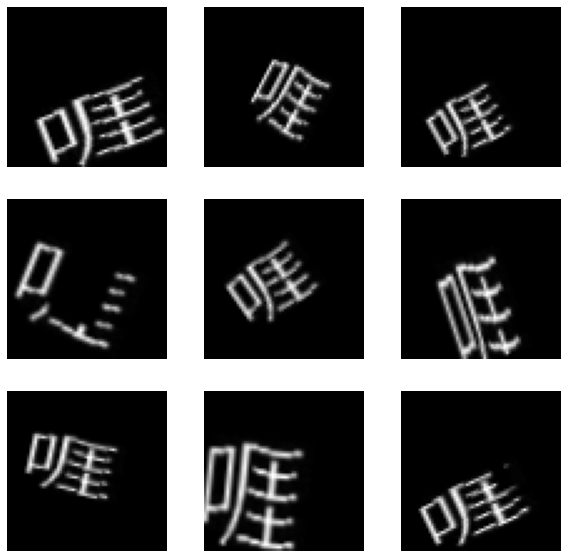

In [17]:
imgs, lbs = [], []
for images, labels in train_dataset:
    for img, label in zip(images, labels):
        imgs.append(img)
        lbs.append(label)
        break
    break
    
plt.figure(figsize=(10, 10))

print(ls[np.argmax(lbs[0])])
for i in range(9):
    augmented_images = img_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().reshape((64, 64)).astype(np.float64), cmap="gray")
    plt.axis("off")

Create an EfficientNet Lite model and merge preprocessing, augmentation layers with it to one model.

In [18]:
from efficientnet_lite import EfficientNetLiteB0

eff_net_lite = EfficientNetLiteB0(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 1),
    classes=len(ls),
    pooling="max",
    classifier_activation="softmax",
)

f16_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, None, 1)),
    PreprocessTFLayer(),
    img_augmentation,
    eff_net_lite,
])
f16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess_tf (PreprocessTFL (None, 64, 64, 1)         0         
_________________________________________________________________
img_augmentation (Sequential (None, None, 64, 1)       0         
_________________________________________________________________
efficientnetlite0 (Functiona (None, 6507)              11747915  
Total params: 11,747,915
Trainable params: 11,705,899
Non-trainable params: 42,016
_________________________________________________________________


Set a path to save model realted files and optionally load stored weights to resume training.

In [19]:
#path where the model should be saved
model_dir = os.path.join(os.getcwd(), "model")
print("model_dir:", model_dir)

#f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-14-0.94.hdf5"))

model_dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model


Set the optimizer, loss function and compile the model

In [20]:
l_r = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=l_r)

METRICS = [
    'accuracy', 
    #tf.keras.metrics.Precision(name='precision'),
    #tf.keras.metrics.Recall(name='recall'),
]

f16_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)

Setup callbacks for the model.

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

#CHECKPOINTS
filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

print("checkpoints dir:", filepath)

# TENSORBOARD
# load the tensorboard extension
%load_ext tensorboard

# add the tensorboard callback
log_dir = os.path.join(model_dir, "tf", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list.append(tensorboard_callback)

print("tensorboard log dir:", log_dir)

# LEARNING RATE SCHEDULER
def scheduler(epoch, lr):
    return l_r - ((l_r / 100 * 4) * (epoch // 3))

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
callbacks_list.append(scheduler_callback)

checkpoints dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5
tensorboard log dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\logs\20210712-170057


Finally train the model on the data set.

In [22]:
#train the model
hist = f16_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    initial_epoch=0,
    workers=16,
    use_multiprocessing=True,
    callbacks=callbacks_list,
)

E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
     98/Unknown - 569s 6s/step - loss: 8.5882 - accuracy: 0.0012

KeyboardInterrupt: 

## Evaluating the model

After training plot the loss and accuracy for the test and validation sets.

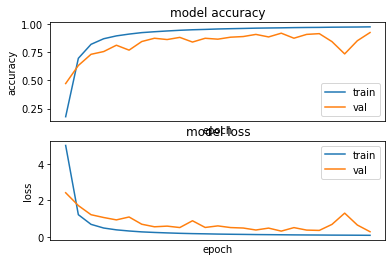

In [34]:
fig, axs = plt.subplots(2)

# accuracy
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='lower right')
axs[0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

# loss
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')
axs[1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)


The graphs look good.
Let's now make a prediction.

In [40]:
# reload weights from file if necessary
#f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints_own_cnn", "weights-improvement-73-0.97.hdf5"))
#f16_model.compile()

['訃', '咏', '泝', '惻', '膚', '茫', '段', '腸', '算', '蓉']


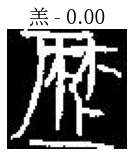

In [16]:
# load a sample
sample = tf.keras.preprocessing.image.load_img(
    path= r"Z:\data_sets\etlcdb\1540\42.jpg",
    color_mode="grayscale",
    target_size=(64, 64)
)

sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = sample.reshape((1, 64, 64, 1)) / 255

# run inference
prediction = eff_net_lite.predict(sample)[0]

# output 10 most liekly predictions
ind = np.argpartition(prediction, -10)[-10:]
q = ind[np.argsort(prediction[ind])]
print([ordered_labels[i] for i in reversed(q)])

# show the most confident prediction and the image
show_image(sample.reshape((64, 64)), ls[prediction.argmax()] + " - %.2f" % prediction.max())

## Fine tune the model with pruning. 

In [ ]:
pass

## Saving the model

The model is perfoming very well therefore save the trained model as a "*.pb" file.

In [34]:
eff_net_lite.save(
    os.path.join(model_dir, "tf", "trained_model"),
)

E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\trained_model\assets


Finally convert the model to a TF-Light model to be used in applications.

In [202]:
# set the dtype policy to float32
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

# Create a new EfficientNet Lite (with float 32) and restore the weights
eff = EfficientNetLiteB0(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 1),
    classes=len(ls),
    pooling="max",
    classifier_activation="softmax"
)
eff.set_weights(f16_model.get_weights())

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, None, 1)),
    PreprocessTFLayer(),
    eff
], name="efficientnet_lite_inference")
model.summary()

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# set quantization, additional ops
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model.
print(os.path.join(model_dir, "tflite", "model.tflite"))
with open(os.path.join(model_dir, "tflite", "model.tflite"), 'wb') as f:
  f.write(tflite_model)


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess_tf (PreprocessTFL (None, 64, 64, 1)         0         
_________________________________________________________________
sequential_29 (Sequential)   (None, 6507)              11747915  
Total params: 11,747,915
Trainable params: 11,705,899
Non-trainable params: 42,016
_________________________________________________________________


E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmpat6o_tq9\assets


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmpat6o_tq9\assets


E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tflite\model.tflite


In [29]:
# create a tf lite interpreter
interpreter = tf.lite.Interpreter(os.path.join(model_dir, "tflite", "model.tflite"))
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = sample
interpreter.set_tensor(input_details[0]['index'], input_data)

# run interpreter
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# show prediction
show_image(sample.reshape(64, 64), ls[output_data.argmax()])

RuntimeError: Encountered unresolved custom op: ScaleAndTranslate.Node number 2 (ScaleAndTranslate) failed to prepare.
